# Proyek Prediksi Harga Rumah (End-to-End)

## 1. Definisi Masalah
Tujuan dari proyek ini adalah untuk memprediksi harga jual rumah (*SalePrice*) berdasarkan berbagai fitur yang ada (seperti luas tanah, kualitas material, tahun dibangun, dll). Ini adalah masalah **Regresi** karena target variabel kita berupa nilai kontinu.

**Tujuan:** Membangun model yang akurat dan men-deploy-nya menjadi aplikasi web sederhana.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Konfigurasi visualisasi
sns.set(style="whitegrid")
%matplotlib inline

## 2. Pengumpulan & Pemuatan Data
Kita menggunakan dataset "House Prices - Advanced Regression Techniques". Data dimuat menggunakan Pandas untuk analisis lebih lanjut.

In [3]:
# Memuat dataset
df = pd.read_csv('train.csv')

# Menampilkan 5 baris pertama
display(df.head())

# Menampilkan informasi umum dataset
print(df.info())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## 3. Eksplorasi Data (Exploratory Data Analysis - EDA)
Langkah ini bertujuan untuk memahami distribusi data target (*SalePrice*) dan melihat korelasi antar fitur.

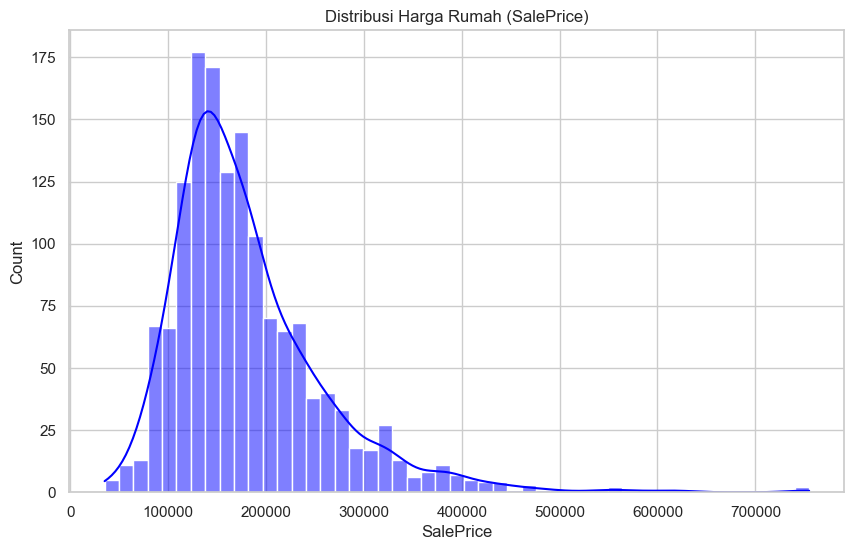

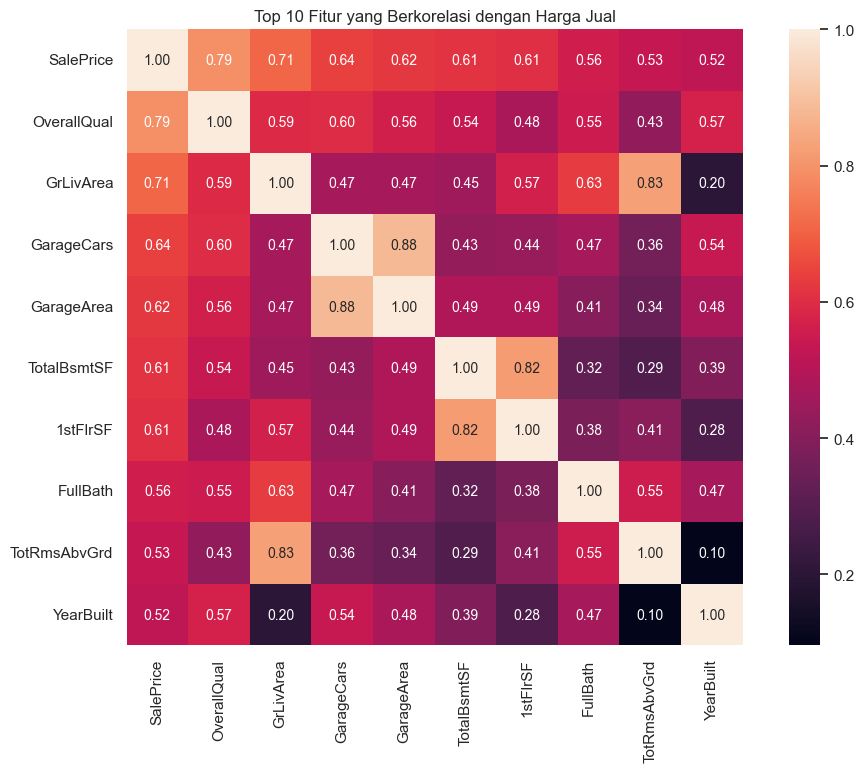

Fitur terpilih untuk model: ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']


In [4]:
# 1. Distribusi Target (SalePrice)
plt.figure(figsize=(10, 6))
sns.histplot(df['SalePrice'], kde=True, color='blue')
plt.title('Distribusi Harga Rumah (SalePrice)')
plt.show()

# 2. Korelasi Fitur Numerik
# Kita hanya mengambil fitur numerik untuk melihat korelasi
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

# Plot Heatmap untuk 10 fitur yang paling berkorelasi dengan SalePrice
k = 10 # jumlah variabel untuk heatmap
cols = correlation_matrix.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.title('Top 10 Fitur yang Berkorelasi dengan Harga Jual')
plt.show()

# Simpan fitur-fitur penting ini untuk pemodelan
selected_features = cols[1:].tolist() # Skip 'SalePrice' itu sendiri
print(f"Fitur terpilih untuk model: {selected_features}")

## 4. Preprocessing Data
Kita akan membersihkan data dengan cara:
1. Memilih hanya fitur-fitur yang memiliki korelasi tinggi (untuk penyederhanaan model & deployment).
2. Mengisi nilai yang hilang (Imputation).
3. Membagi data menjadi Training dan Testing set.

In [5]:
# Memilih fitur (X) dan target (y)
# Kita menggunakan fitur dari hasil EDA sebelumnya agar aplikasi streamlit nanti tidak terlalu rumit
X = df[selected_features]
y = df['SalePrice']

# Cek Missing Values
print("Missing values sebelum handling:\n", X.isnull().sum())

# Handling Missing Values (Mengisi dengan Median)
# Catatan: Untuk proyek nyata yang lebih kompleks, penanganan bisa lebih spesifik per kolom
for col in X.columns:
    X[col] = X[col].fillna(X[col].median())

# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nShape X_train: {X_train.shape}")
print(f"Shape X_test: {X_test.shape}")

Missing values sebelum handling:
 OverallQual     0
GrLivArea       0
GarageCars      0
GarageArea      0
TotalBsmtSF     0
1stFlrSF        0
FullBath        0
TotRmsAbvGrd    0
YearBuilt       0
dtype: int64

Shape X_train: (1168, 9)
Shape X_test: (292, 9)


C:\Users\xeltr\AppData\Local\Temp\ipykernel_11760\64091838.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].fillna(X[col].median())
C:\Users\xeltr\AppData\Local\Temp\ipykernel_11760\64091838.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].fillna(X[col].median())
C:\Users\xeltr\AppData\Local\Temp\ipykernel_11760\64091838.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

## 5. Pelatihan Model (Model Training)
Kita akan menggunakan algoritma **Random Forest Regressor**. Algoritma ini dipilih karena ketangguhannya terhadap outlier dan kemampuan menangkap hubungan non-linear.

In [6]:
# Inisialisasi Model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Training Model
model.fit(X_train, y_train)

print("Pelatihan model selesai.")

Pelatihan model selesai.


## 6. Evaluasi Model
Kita mengevaluasi performa model menggunakan metrik:
* **MAE (Mean Absolute Error):** Rata-rata kesalahan absolut.
* **RMSE (Root Mean Squared Error):** Penalti lebih besar untuk kesalahan besar.
* **R2 Score:** Seberapa baik model menjelaskan variasi data.

Mean Absolute Error (MAE): $19,052.91
Root Mean Squared Error (RMSE): $29,602.88
R2 Score: 0.8858


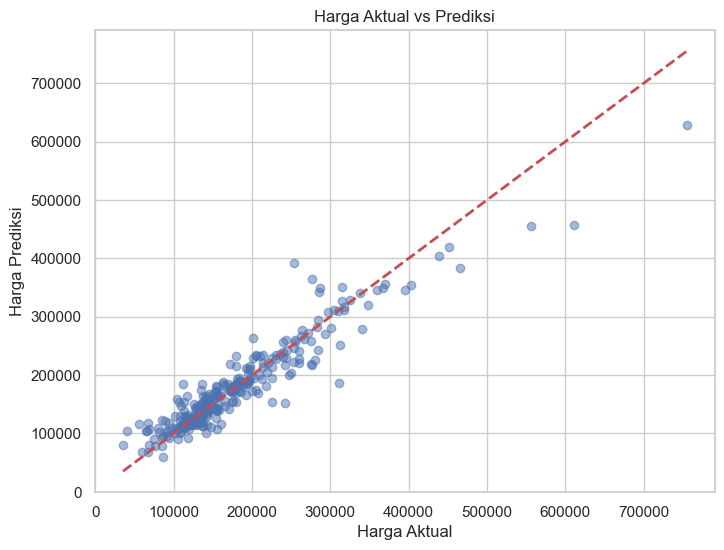

In [7]:
# Prediksi data test
y_pred = model.predict(X_test)

# Hitung Metrik
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")
print(f"R2 Score: {r2:.4f}")

# Visualisasi Prediksi vs Aktual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Harga Aktual')
plt.ylabel('Harga Prediksi')
plt.title('Harga Aktual vs Prediksi')
plt.show()

## 7. Menyimpan Model
Menyimpan model yang sudah dilatih agar bisa digunakan di aplikasi Streamlit tanpa perlu training ulang.

In [8]:
# Menyimpan model
joblib.dump(model, 'house_price_model.pkl')

# Menyimpan nama kolom untuk referensi saat deployment
joblib.dump(selected_features, 'model_features.pkl')

print("Model dan fitur berhasil disimpan!")

Model dan fitur berhasil disimpan!
